<h4> Import necessary modules </h4>

In [1]:
import investpy
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

<h4> Get Microsoft Stock prices for 10 years </h4>

In [2]:
stock_prices = investpy.get_stock_historical_data(stock='MSFT',country='United States',from_date='01/01/2010',to_date='31/12/2020')

In [3]:
stock_prices.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-01-04,30.62,31.10,30.59,30.95,38414184,USD
2010-01-05,30.85,31.10,30.64,30.96,49758864,USD
2010-01-06,30.88,31.08,30.52,30.77,58182332,USD
2010-01-07,30.63,30.70,30.19,30.45,50564284,USD
2010-01-08,30.28,30.88,30.24,30.66,51201288,USD


In [4]:
stock_prices.tail()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-12-24,221.42,223.61,221.20,222.75,10550572,USD
2020-12-28,224.50,225.99,223.03,224.96,17933496,USD
2020-12-29,226.03,227.15,223.60,224.15,17403212,USD
2020-12-30,225.00,225.62,221.50,221.68,20272336,USD
2020-12-31,221.70,223.00,219.68,222.42,20942132,USD


In [5]:
stock_prices = stock_prices.reset_index()

In [6]:
stock_prices.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2010-01-04,30.62,31.10,30.59,30.95,38414184,USD
1,2010-01-05,30.85,31.10,30.64,30.96,49758864,USD
2,2010-01-06,30.88,31.08,30.52,30.77,58182332,USD
3,2010-01-07,30.63,30.70,30.19,30.45,50564284,USD
4,2010-01-08,30.28,30.88,30.24,30.66,51201288,USD


In [7]:
stock_prices = stock_prices[['Date','Close']]
stock_prices.head()

,Date,Close
0,2010-01-04,30.95
1,2010-01-05,30.96
2,2010-01-06,30.77
3,2010-01-07,30.45
4,2010-01-08,30.66


<h2> Plotting the stock prices over time</h2>

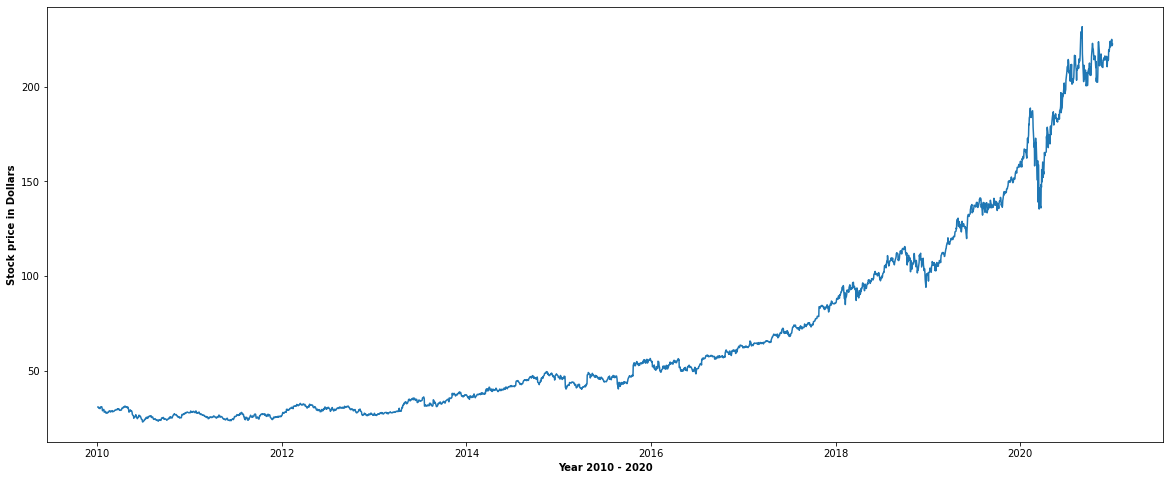

In [8]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))
ax.set_xlabel('Year 2010 - 2020', fontweight ='bold')
ax.set_ylabel('Stock price in Dollars', fontweight ='bold')
ax.plot(stock_prices.Date.values, stock_prices.Close.values)
plt.show()

<h2> Helper Functions </h2>

In [9]:
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i : (i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)        

In [10]:
def pre_process_inputs(X,  time_step=60):
  sc = MinMaxScaler(feature_range=(0,1))
  X = sc.fit_transform(np.array(X).reshape(-1,1))

  training_size = int(len(X) * 0.65)
  test_size = len(X) - training_size
  train_data, test_data = X[0:training_size,:], X[training_size:len(X),:]

 
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)

  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  return X_train, y_train, X_test, y_test, sc 

In [11]:
stock_before_2020 = stock_prices[(stock_prices['Date'] < '2020-01-01')].Close.values
time_step = 100
X_train, y_train, X_test, y_test, sc = pre_process_inputs(stock_before_2020, time_step)

In [12]:
def createPredictionModel(time_step):
  model=Sequential()
  model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
  model.add(LSTM(50,return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam') 

  return model

<h3> Create model and train</h3>

In [13]:
model = createPredictionModel(time_step)

In [14]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 9s 220ms/step - loss: 0.0042 - val_loss: 5.7179e-04
Epoch 2/100
24/24 [==============================] - 4s 164ms/step - loss: 2.4069e-04 - val_loss: 0.0020
Epoch 3/100
24/24 [==============================] - 4s 162ms/step - loss: 1.2647e-04 - val_loss: 0.0015
Epoch 4/100
24/24 [==============================] - 4s 163ms/step - loss: 1.1829e-04 - val_loss: 0.0016
Epoch 5/100
24/24 [==============================] - 4s 162ms/step - loss: 1.1422e-04 - val_loss: 0.0027
Epoch 6/100
24/24 [==============================] - 4s 165ms/step - loss: 1.1258e-04 - val_loss: 0.0040
Epoch 7/100
24/24 [==============================] - 4s 165ms/step - loss: 1.0806e-04 - val_loss: 0.0039
Epoch 8/100
24/24 [==============================] - 4s 163ms/step - loss: 9.4734e-05 - val_loss: 0.0049
Epoch 9/100
24/24 [==============================] - 4s 164ms/step - loss: 9.8755e-05 - val_loss: 0.0026
Epoch 10/100
24/24 [==============================] - 4

In [15]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

train = np.concatenate((train_predict, test_predict))

<h2> Predicted vs Actual for the year 2010-2019</h2>

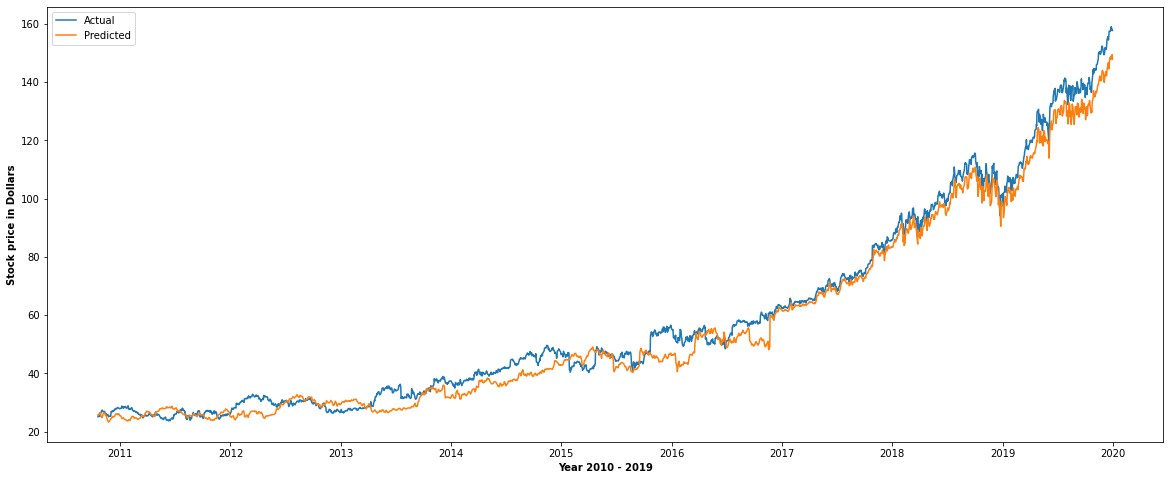

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))
stock_before_2020 = stock_prices[(stock_prices['Date'] < '2020-01-01')]
ax.plot(stock_before_2020.Date.values[2 * time_step:], stock_before_2020.Close.values[2 * time_step:], stock_before_2020.Date.values[2 * time_step:], train)
ax.set_xlabel('Year 2010 - 2019', fontweight ='bold')
ax.set_ylabel('Stock price in Dollars', fontweight ='bold')
ax.legend(['Actual','Predicted'])
plt.show()

<h3> Now predicting for year 2020 </h3>

In [20]:
stock_2020 = stock_prices[(stock_prices['Date'] > '2019-12-31')]

<h4> Predict </h4>

In [23]:
stock_predict_2020 = []
stock_actual_2020 = stock_2020.Close.values
stock_before_2020 = stock_prices[(stock_prices['Date'] < '2020-01-01')].Close.values
look_back = stock_before_2020[-1*time_step:]


stock_actual_2020 = sc.fit_transform(stock_actual_2020.reshape(-1, 1))

for i in range(int(stock_actual_2020.shape[0])):
  look_back = look_back.reshape(1,time_step,1)
  stock_predict_2020.append(model.predict(look_back, verbose=0)[0][0])
  look_back = look_back[0,1:,0]
  look_back = np.concatenate((look_back, [stock_actual_2020[i,0]]))

stock_predict_2020 = sc.inverse_transform(np.array(stock_predict_2020).reshape(-1,1))

<h4> Prediction for year 2020 </h4>

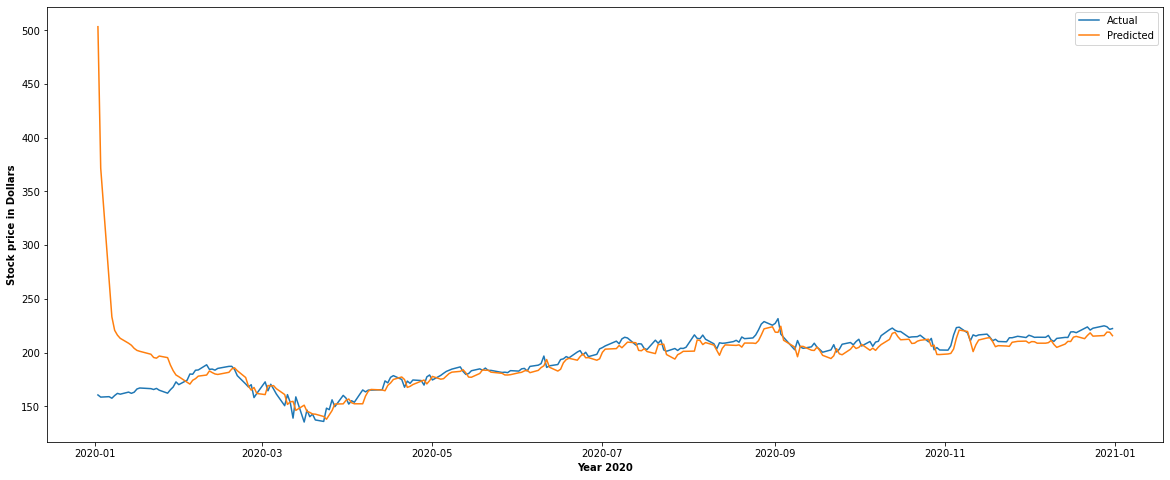

In [24]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))
ax.plot(stock_2020.Date.values, stock_2020.Close.values, stock_2020.Date.values, stock_predict_2020)
ax.set_xlabel('Year 2020', fontweight ='bold')
ax.set_ylabel('Stock price in Dollars', fontweight ='bold')
ax.legend(['Actual','Predicted'])
plt.show()